In [1]:
import map_projection as mp
import datetime
import matplotlib.pyplot as plt
import astropy.units as u
from nustar_pysolar import planning, io

Issues with nustar_pysolar and conda? Just copy & paste the nustar_pysolar folder in the nust_pysolar folder into your conda environment path then manually install Python's wget via ```conda install -n environmentName conda-forge::python-wget```

In [2]:
# NuSTAR FOV anti-clockwise rotation from solar north in degrees (Det0 in top left originally)
nu_SNangle = 0 

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Got AIA map.


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Got STEREO-A map.
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


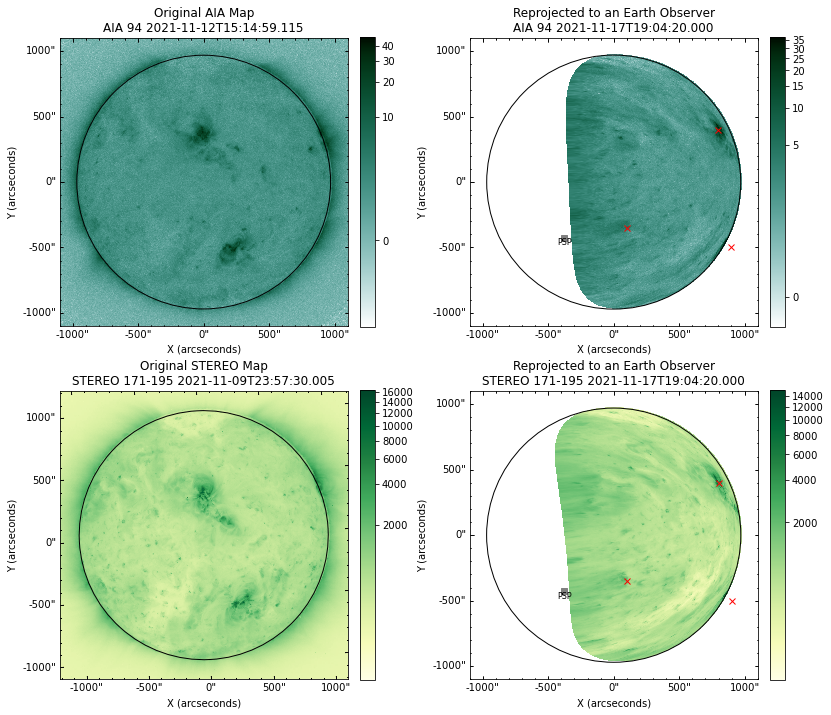

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Got AIA map.


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Got STEREO-A map.
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


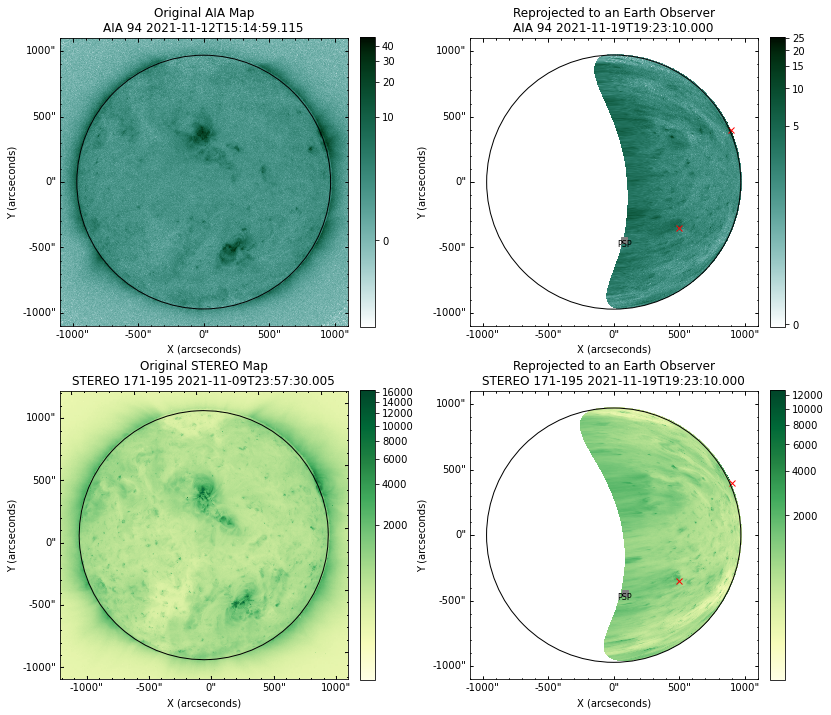

In [3]:
# # Example
#
# t_obs_proj = '2021-11-17T14:45:00'
# # t_obs_start = (datetime.datetime.now()+datetime.timedelta(days=5)).strftime("%Y-%m-%dT%H:%M:%S")
# nustar_center = [800,400] # NuSTAR FOV centre in arcsec, [0,0] is sun centre, +West, +North
#
# plt.figure(figsize=(13,12))
# axes = mp.reprojection(t_obs_proj, *nustar_center, [-100, 0, 100], rotate=nu_SNangle)
# plt.savefig('./aia_stereo_projection.jpg', bbox_inches="tight")
# plt.show()


# Nov.17
t_obs_proj = '2021-11-17T19:04:20'
nustar_center = [800,400] # NuSTAR FOV centre in arcsec, [0,0] is sun centre, +West, +North
psp_loc = [-377.90712101827400, -429.2828588884080] # @~18:00:00, from consensus file

plt.figure(figsize=(13,12))
x_poi17, y_poi17 = [800, 900, 100], [400, -500, -350]  # points of interest
axes = mp.reprojection(t_obs_proj, *nustar_center, [], rotate=nu_SNangle, 
                       markers=[x_poi17, y_poi17], psp_loc=psp_loc)
plt.savefig('./aia_stereo_projection_Nov_17.jpg', bbox_inches="tight")
plt.show()


# Nov 19
t_obs_proj = '2021-11-19T19:23:10'
nustar_center = [800,400] # NuSTAR FOV centre in arcsec, [0,0] is sun centre, +West, +North
psp_loc = [82.3468873479248, -442.7510665241240] # @~18:00:00, from consensus file

plt.figure(figsize=(13,12))
x_poi19, y_poi19 = [900, 500], [400, -350]  # points of interest
axes = mp.reprojection(t_obs_proj, *nustar_center, [], rotate=nu_SNangle, 
                       markers=[x_poi19, y_poi19], psp_loc=psp_loc)
plt.savefig('./aia_stereo_projection_Nov_19.jpg', bbox_inches="tight")
plt.show()

***

**Brian's example on NuSTAR solar observation planning (https://github.com/NuSTAR/nustar_pysolar/blob/main/notebooks/Planning_Example.ipynb).**

**I did have to go an manually download the planet ephemeris data file de436.bsp from https://ssd.jpl.nasa.gov/ftp/eph/planets/bsp/ since nustar_pysolar kept timing out with the website. This file is also too large to uplaod to Github.**

You might want to adjust the tstart from above to look over the whole observing period for NuSTAR insterad of just starting at the time the maps are projected onto.

In [ ]:
t_obs_starts = ['2021-11-17T14:29:00', '2021-11-19T14:29:00', '2021-11-21T14:50:00']
t_obs_durs = [{"hours":13}, {"hours":13}, {"hours":11}]
t_obs_ends = [(datetime.datetime.strptime(t_obs_start, "%Y-%m-%dT%H:%M:%S")+datetime.timedelta(**t_obs_dur)).strftime("%Y-%m-%dT%H:%M:%S") for t_obs_start, t_obs_dur in zip(t_obs_starts, t_obs_durs)]

In [ ]:
# Use Brian's planning Notebook: https://github.com/NuSTAR/nustar_pysolar/blob/main/notebooks/Planning_Example.ipynb

for t_obs_start, t_obs_dur, t_obs_end in zip(t_obs_starts, t_obs_durs, t_obs_ends):
    # Get occultation period times
    fname = io.download_occultation_times(outdir='./data/')

    # Define observing window
    orbits = planning.sunlight_periods(fname, tstart=t_obs_start, tend=t_obs_end)

    # Calculate the PA angle
    pa = planning.get_nustar_roll(t_obs_start, nu_SNangle<<u.deg) # angle is anti-clockwise starting with Det0 in top-left
    print("For a \"square\" field of view, use angle=0 / 90 / 180 / 270 to have DET0 at the \nNE (top left) / SE / SW / NW corners of a square field of view.")
    print("NuSTAR Roll angle for anti-clockwise rotation of {} deg from SN @ {}: {}\n".format(nu_SNangle, t_obs_start, pa))

    # Define offset, +West, +North
    offset = nustar_center*u.arcsec

    # Loop over orbits and find pointing in RA/Dec
    print("\nStarting @ ", t_obs_start)
    for ind, orbit in enumerate(orbits):
        midTime = (0.5*(orbit[1] - orbit[0]) + orbit[0])
        sky_pos = planning.get_skyfield_position(midTime, offset, load_path='./data', parallax_correction=True)
        print("\nOrbit: {}".format(ind))
        print("Orbit start: {} -> Orbit end: {}".format(orbit[0], orbit[1]))
        print('Aim time: {} RA: {}, Dec: {}\n'.format(midTime, sky_pos[0], sky_pos[1]))
    print("\n\n")

***

***